In [84]:
# Imports
import os
import sys
import json
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.interpolate import interp1d
import datetime
import pandas as pd
import ipywidgets as widgets

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.backendConnect.graphQLQueries import plant_state_query, plant_opt_query
from src.backendConnect.graphQLClient import GraphQLClient

# Fetch data from API

In [144]:
select = widgets.SelectMultiple(
    options=['TestA','TestB','TestL','TestL2'],
    value=['TestB'],
    #rows=10,
    description='Tobias plants',
    disabled=False
)
plants = {
    "TestA": "cjj4big9i07t90818w9rnv86r",
    "TestB": "cjj4bor6w09an0818ziyivwwb",
    "TestL": "cjj6vhd3ulhlv0818g64xgf57",
    "TestL2": "cjj6vpa6gliur0818z0l86eru"
}
widgets.VBox([select])

In [145]:
plant_id = plants[select.value[0]]

In [146]:
def fetch_vals(client, plantId, stop_at=1000):
    start_index = 0
    new_data = True
    while (new_data):
        query = plant_state_query(plant_id, first=1000, skip=start_index)
        response = client.execute(query)
        plantStates = json.loads(response)['data']['plant']['plantStates']
        new_data_len = len(plantStates)
        if new_data_len == 0:
            new_data = False
        start_index += new_data_len
        yield plantStates
    
def fetch_opt_vals(client, plant_id):
    query = plant_opt_query(plant_id)
    response = client.execute(query)
    plant = json.loads(response)['data']['plant']
    return plant

    
def extract_time(plantState):
    raw_date = plantState['sensorDates']['timeStamp']
    return raw_date


In [147]:
uri = 'http://167.99.240.197:4466/plantsdb/dev'
client = GraphQLClient(uri)

opt_vals = fetch_opt_vals(client, plant_id)

if(os.path.isfile(f'./df_{plant_id}.pkl')):
    df = pd.read_pickle(f'./df_{plant_id}.pkl')
else:
    plantStates = [val for vals in fetch_vals(client, plant_id) for val in vals]

    time_stamps = pd.to_datetime(list(map(extract_time, plantStates)))
    env_vals = list(map(lambda x: x['environment'], plantStates))
    health_vals = list(map(lambda x: x['health'], plantStates))
    size_vals = list(map(lambda x: x['size'], plantStates))
    temp_vals = list(map(lambda x: x['sensorDates']['temperatureValue'], plantStates))
    hum_vals = list(map(lambda x: x['sensorDates']['humidityValue'], plantStates))
    rad_vals = list(map(lambda x: x['sensorDates']['radiationValue'], plantStates))
    loud_vals = list(map(lambda x: x['sensorDates']['loudnessValue'], plantStates))
    data = {
        'date': time_stamps,
        'humidity': hum_vals,
        'radiation': rad_vals,
        'loudness': loud_vals,
        'temperature': temp_vals,
        'health': health_vals,
        'environment': env_vals,
        'size': size_vals
    }
    columns = ['environment', 'humidity', 'radiation', 'loudness','temperature', 'health', 'size']
    df = pd.DataFrame(data, index =time_stamps)
    df.set_index('date',inplace=True)

    df.to_pickle(f'./df_{plant_id}') 


In [148]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


/Users/leonardeyer/Documents/Uni/SS18/PCPS/PI/venv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['select']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Sampling data

In [150]:
start = dt.datetime(2018,7,7,5,30,0) #TEST L2 15:46 #TEST L 7.07 5:30
end = dt.datetime(2018,7,9,23,0,0)
mask = (df.index > start) & (df.index <= end)
rng = df.loc[mask]

slim = rng
slim = rng.sample(n= 3000, replace=True)

### Health and Environment

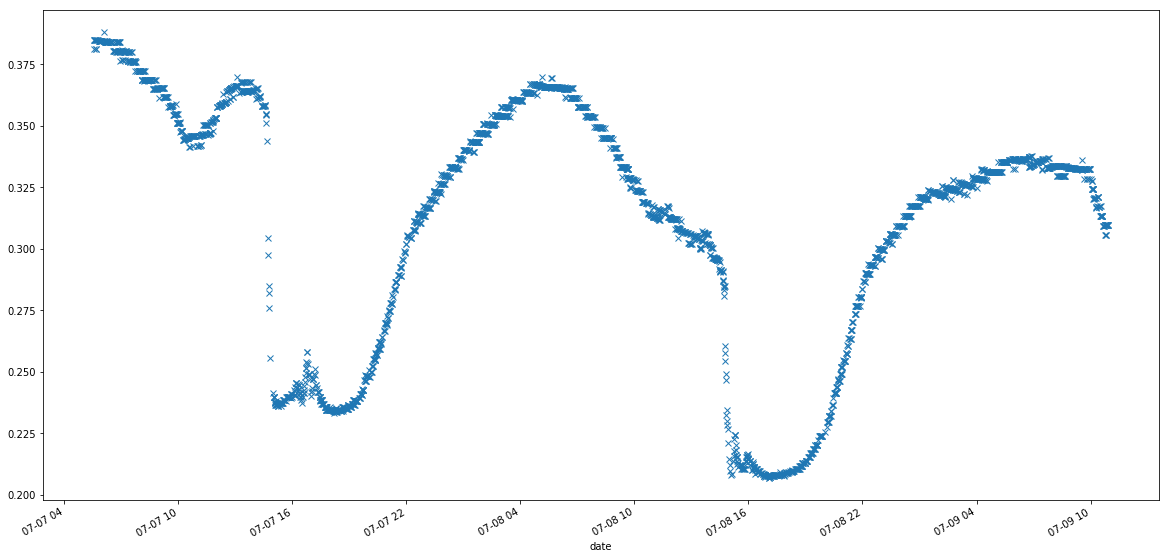

In [151]:
slim['environment'].plot(style='x')

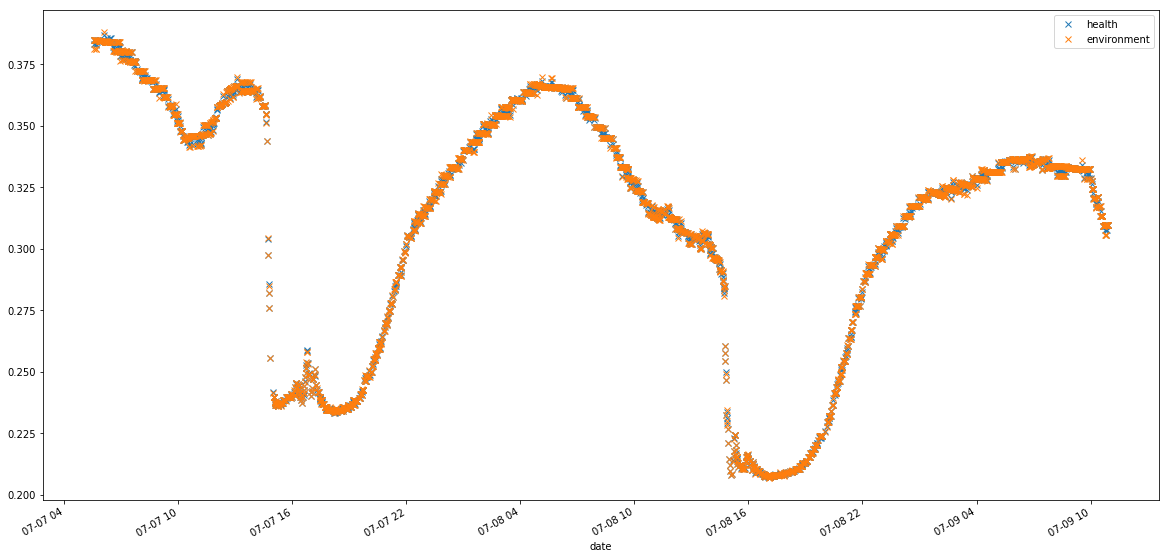

In [152]:
slim[['health', 'environment']].plot(style='x')

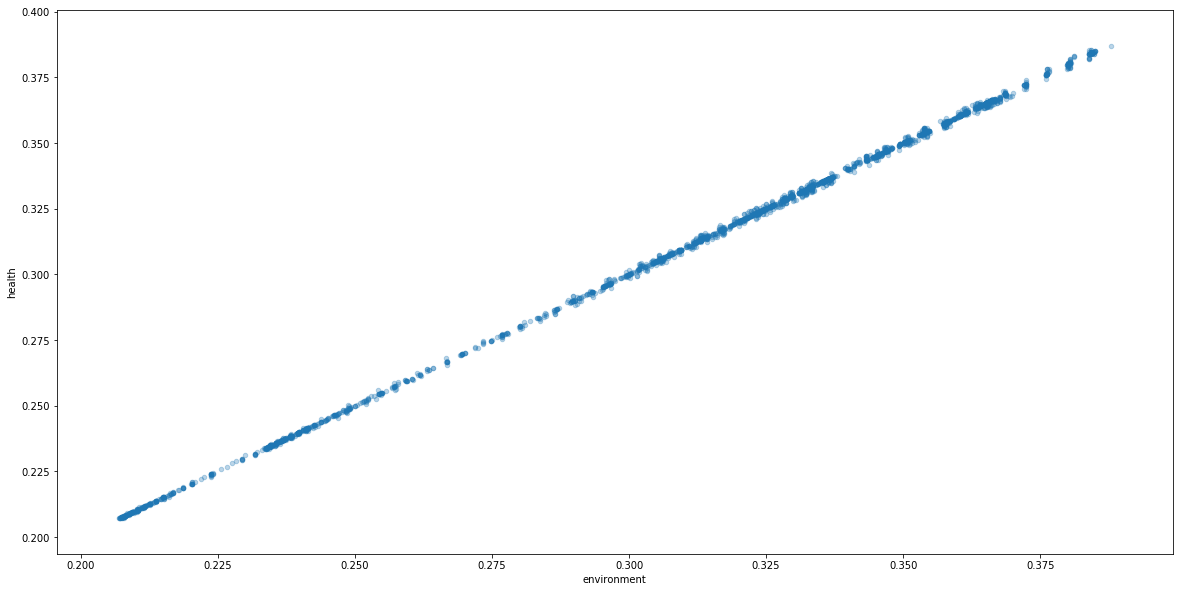

In [153]:
slim[['health', 'environment']].plot.scatter(x = 'environment', y= 'health', alpha=0.3)

### Temperature and Humidity

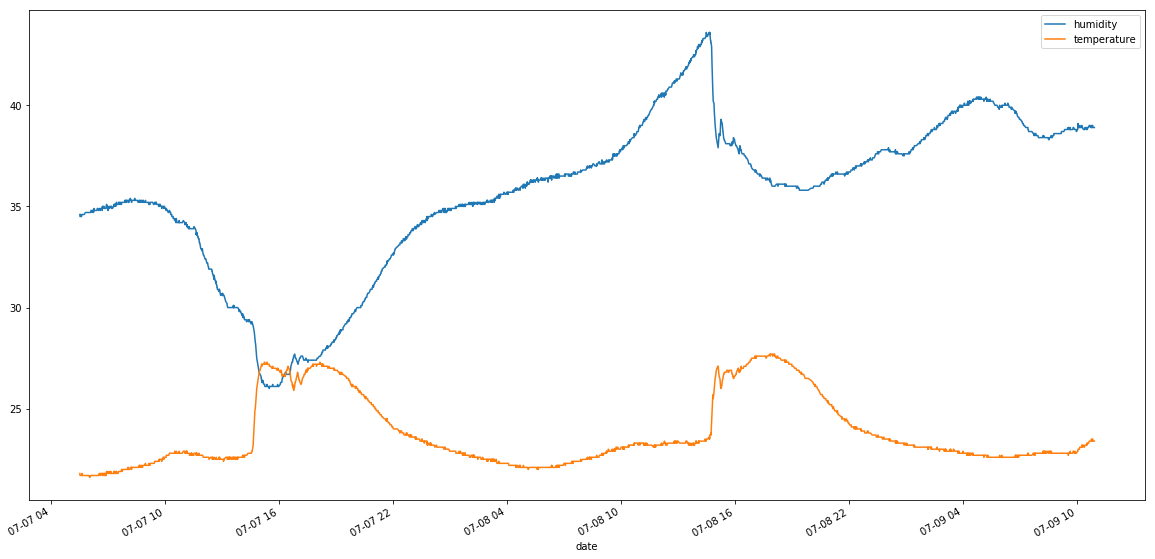

In [154]:
slim[['humidity', 'temperature']].plot()

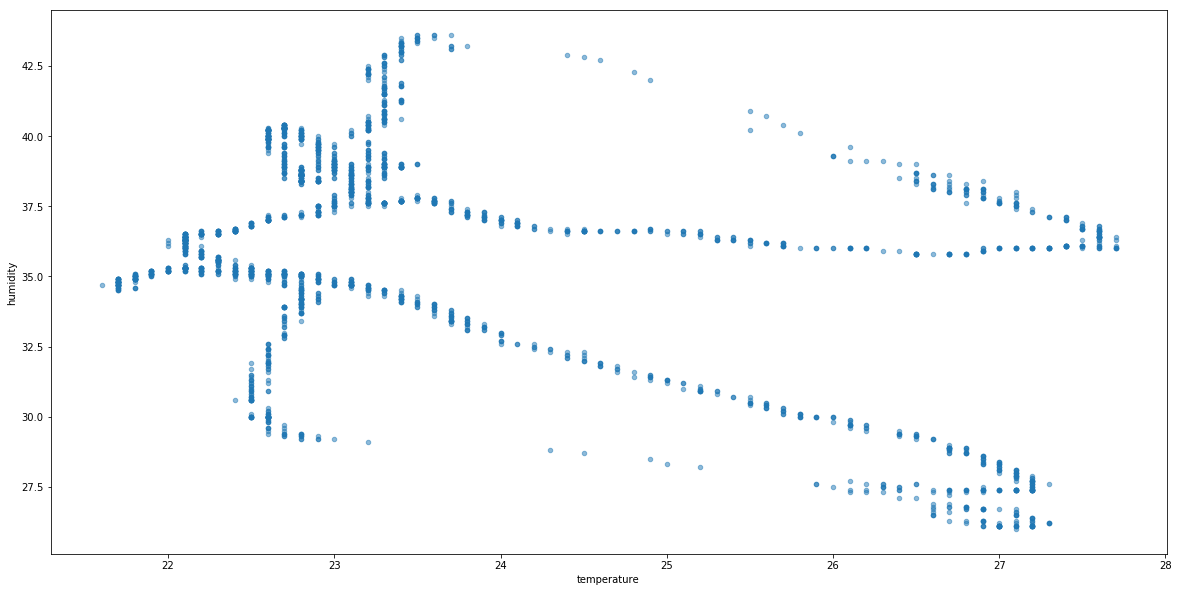

In [155]:
slim[['humidity', 'temperature']].plot.scatter(y = 'humidity', x= 'temperature', alpha=0.5)

### Radiation

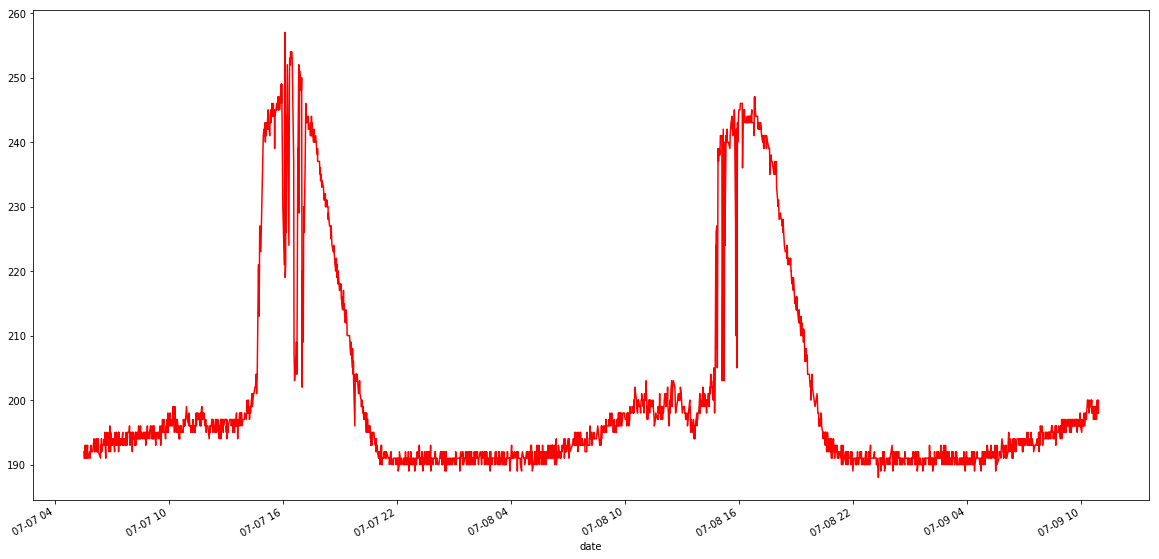

In [156]:
slim['radiation'].sub(opt_vals['radiation_opt']).plot(style='r-')

### Loudness

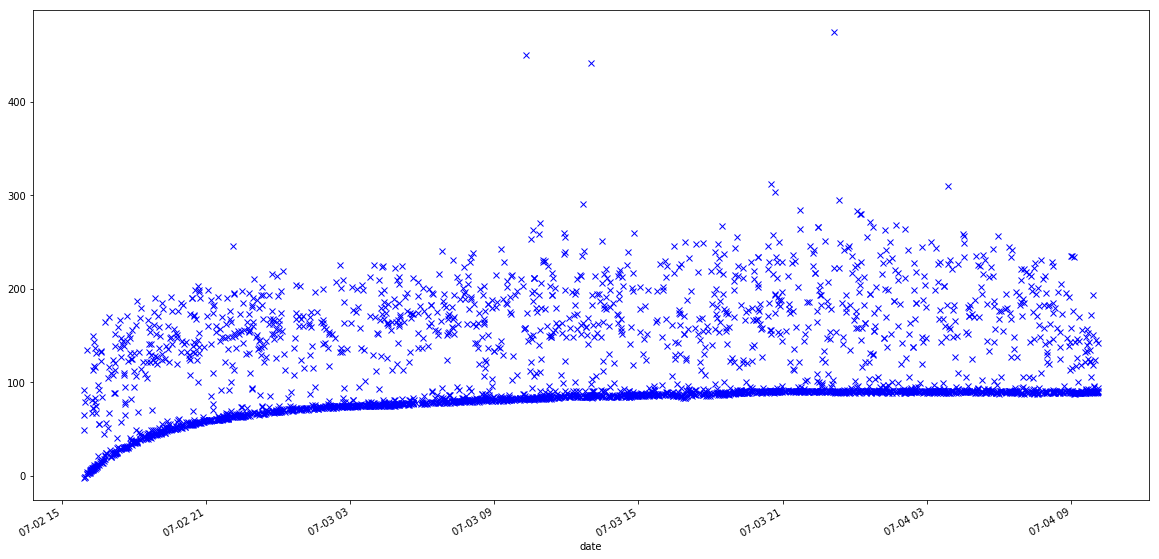

In [124]:
slim['loudness'].sub(opt_vals['loudness_opt']).plot(style='bx')

### Size

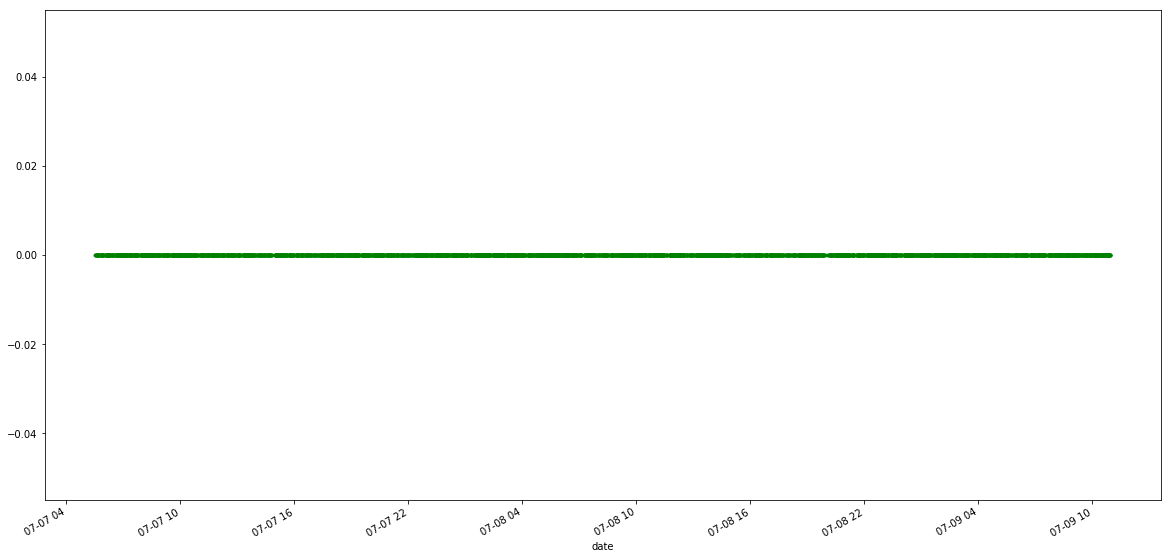

In [157]:
slim['size'].plot(style='g.-')